In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import recall_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from catboost import CatBoostClassifier, Pool, cv
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/obulygin/content/main/SeoulBike/seoul_bike_data.csv', encoding='cp1251')
df.describe()
df.nunique()

Date                          365
Rented Bike Count            2166
Hour                           24
Temperature(°C)               546
Humidity(%)                    90
Wind speed (m/s)               65
Visibility (10m)             1789
Dew point temperature(°C)     556
Solar Radiation (MJ/m2)       345
Rainfall(mm)                   61
Snowfall (cm)                  51
Seasons                         4
Holiday                         2
Functioning Day                 2
dtype: int64

In [3]:
# проверяем на наличие дубликатов
df.duplicated().sum()

0

In [4]:
# выводим инфо о количестве каждого уникального значения для каждого столбца
feature_names = df.columns.tolist()
for column in feature_names:
    print (column)
    print (df[column].value_counts(dropna=False))

Date
Date
01/12/2017    24
09/08/2018    24
07/08/2018    24
06/08/2018    24
05/08/2018    24
              ..
31/03/2018    24
30/03/2018    24
29/03/2018    24
28/03/2018    24
30/11/2018    24
Name: count, Length: 365, dtype: int64
Rented Bike Count
Rented Bike Count
0       295
122      19
223      19
262      19
165      18
       ... 
2096      1
2440      1
1600      1
3384      1
595       1
Name: count, Length: 2166, dtype: int64
Hour
Hour
0     365
1     365
22    365
21    365
20    365
19    365
18    365
17    365
16    365
15    365
14    365
13    365
12    365
11    365
10    365
9     365
8     365
7     365
6     365
5     365
4     365
3     365
2     365
23    365
Name: count, dtype: int64
Temperature(°C)
Temperature(°C)
 19.1    40
 20.5    40
 23.4    39
 7.6     38
 20.7    38
         ..
-13.6     1
-12.9     1
-12.6     1
 37.6     1
 36.9     1
Name: count, Length: 546, dtype: int64
Humidity(%)
Humidity(%)
53    173
97    173
43    164
57    159
56    157
   

In [5]:
# проверяем на наличие пропусков
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [6]:
# переименовываем столбцы
data = df.rename(columns={'Rented Bike Count': 'Rented_bike_count',
                                              'Temperature(°C)': 'Temperature',
                                              'Humidity(%)': 'Humidity',
                                              'Wind speed (m/s)': 'Wind_speed',
                                              'Visibility (10m)': 'Visibility',
                                              'Dew point temperature(°C)': 'Dew_point_temperature',
                                              'Solar Radiation (MJ/m2)': 'Solar_radiation',
                                              'Snowfall (cm)': 'Snowfall',
                                              'Functioning Day': 'Functioning_day',
                                              'Rainfall(mm)': 'Rainfall'
                                              })


In [7]:
# меняем формат столбца дата, чтобы взять оттуда инфо для двух новых столбцов
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['day_of_week'] = data['Date'].dt.day_name()
data['month'] = data['Date'].dt.month_name()

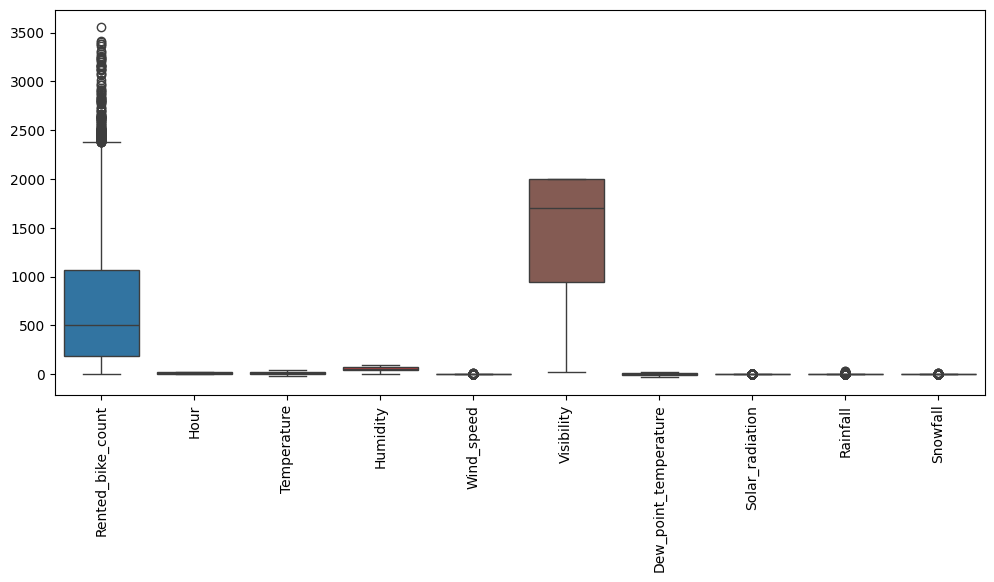

In [8]:
data = data.drop(['Date'], axis=1)
plt.figure(figsize=(12, 5))
plot = sns.boxplot(data=data)
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plt.show()

array([[<Axes: title={'center': 'Rented_bike_count'}>,
        <Axes: title={'center': 'Hour'}>,
        <Axes: title={'center': 'Temperature'}>],
       [<Axes: title={'center': 'Humidity'}>,
        <Axes: title={'center': 'Wind_speed'}>,
        <Axes: title={'center': 'Visibility'}>],
       [<Axes: title={'center': 'Dew_point_temperature'}>,
        <Axes: title={'center': 'Solar_radiation'}>,
        <Axes: title={'center': 'Rainfall'}>],
       [<Axes: title={'center': 'Snowfall'}>, <Axes: >, <Axes: >]],
      dtype=object)

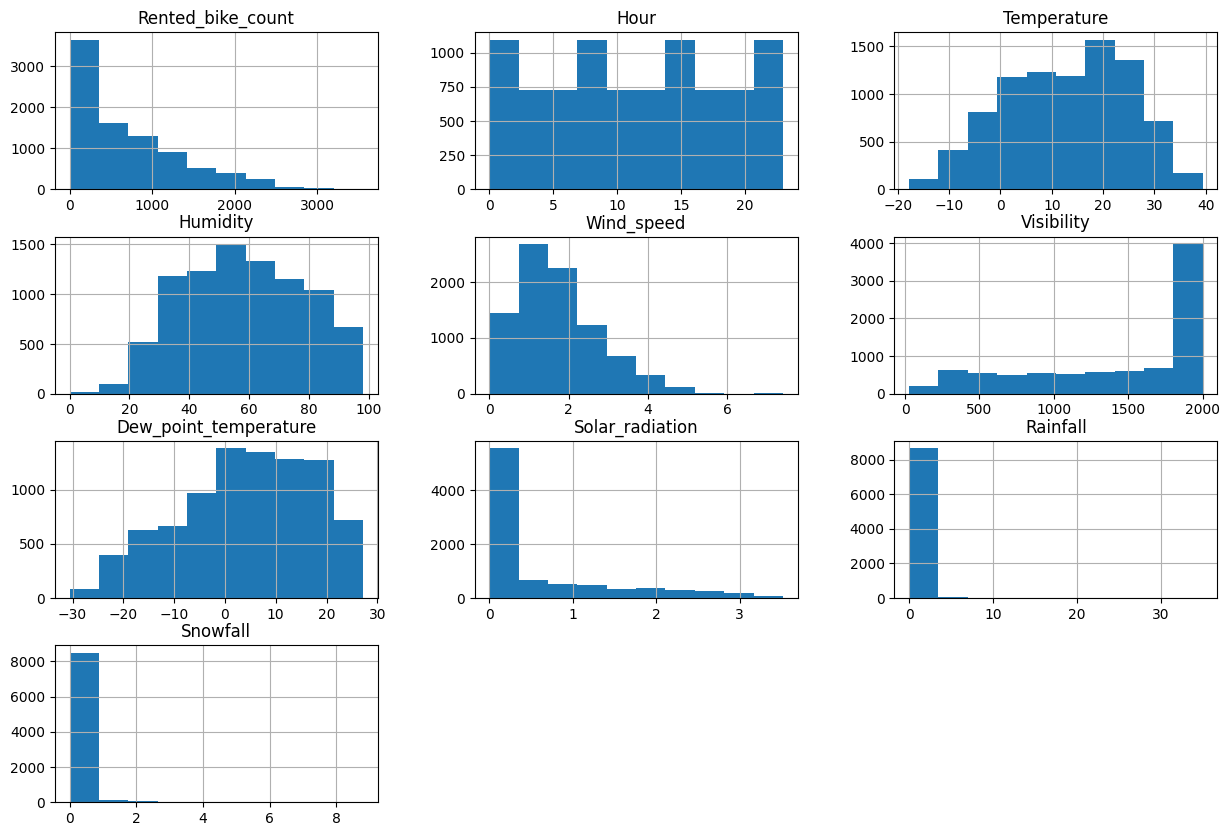

In [9]:
data.hist(figsize=(15,10))

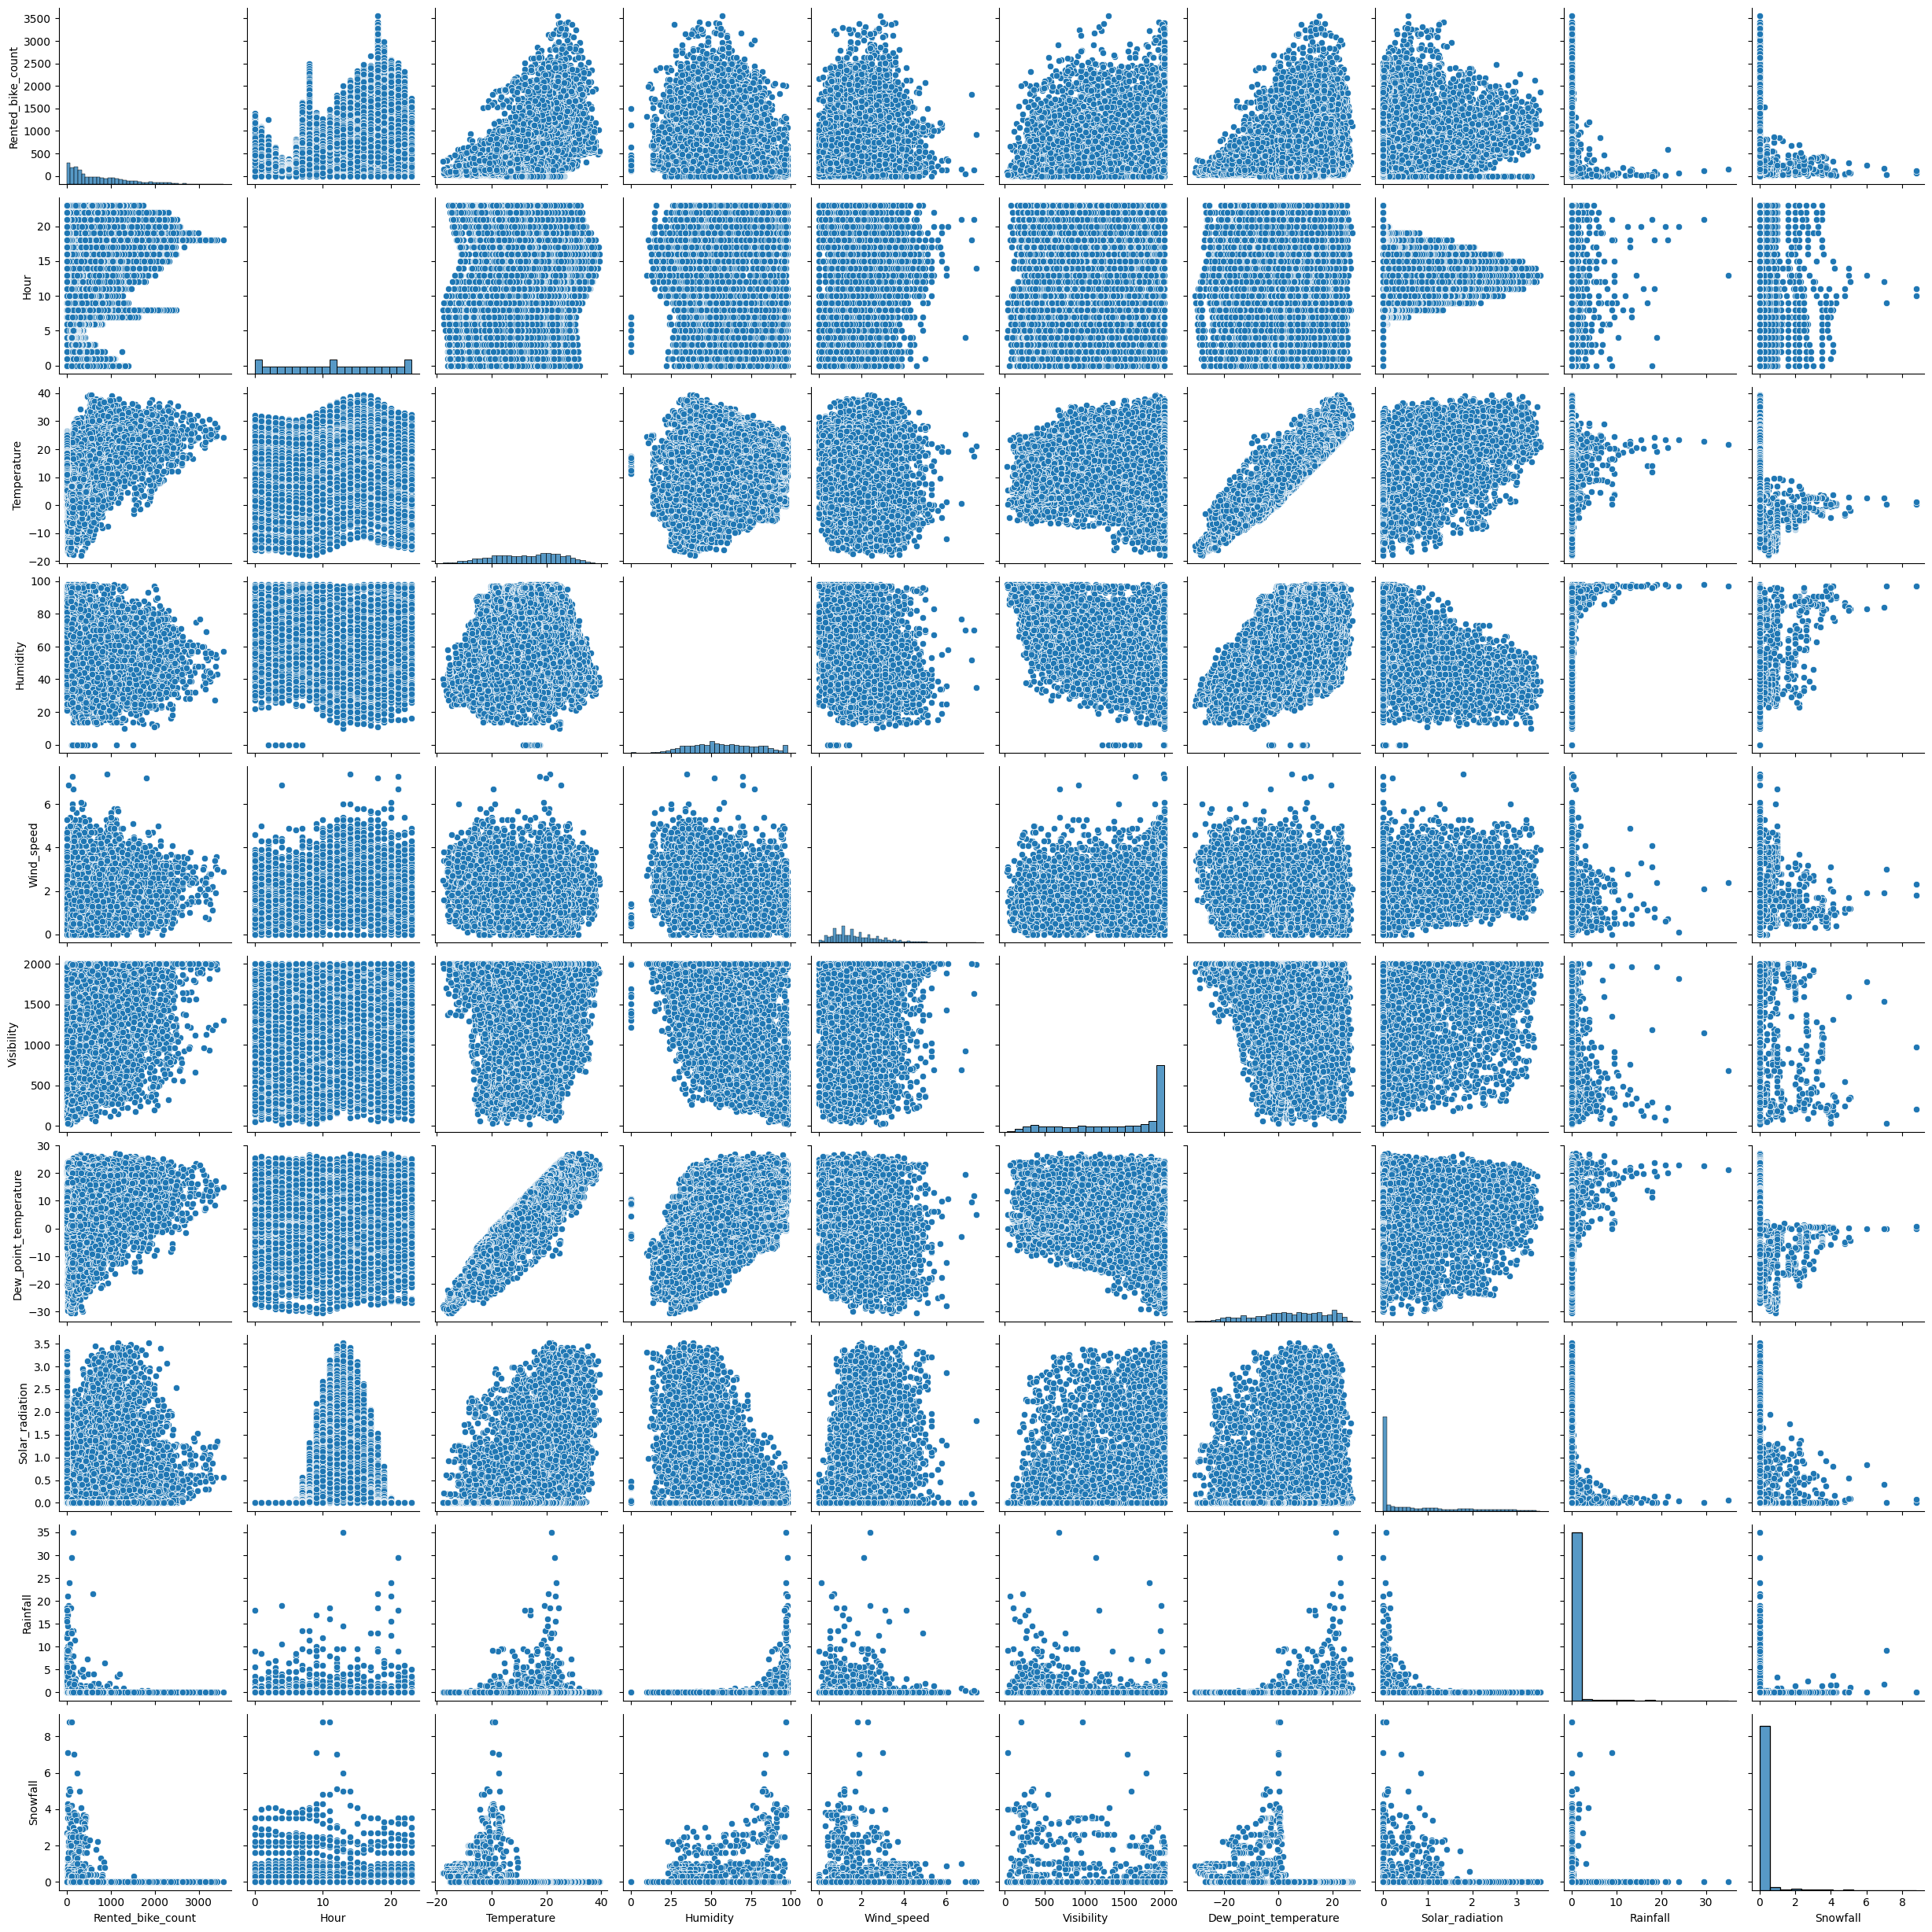

In [10]:
sns.pairplot(data)

interval columns not set, guessing: ['Rented_bike_count', 'Hour', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Solar_radiation', 'Rainfall', 'Snowfall']


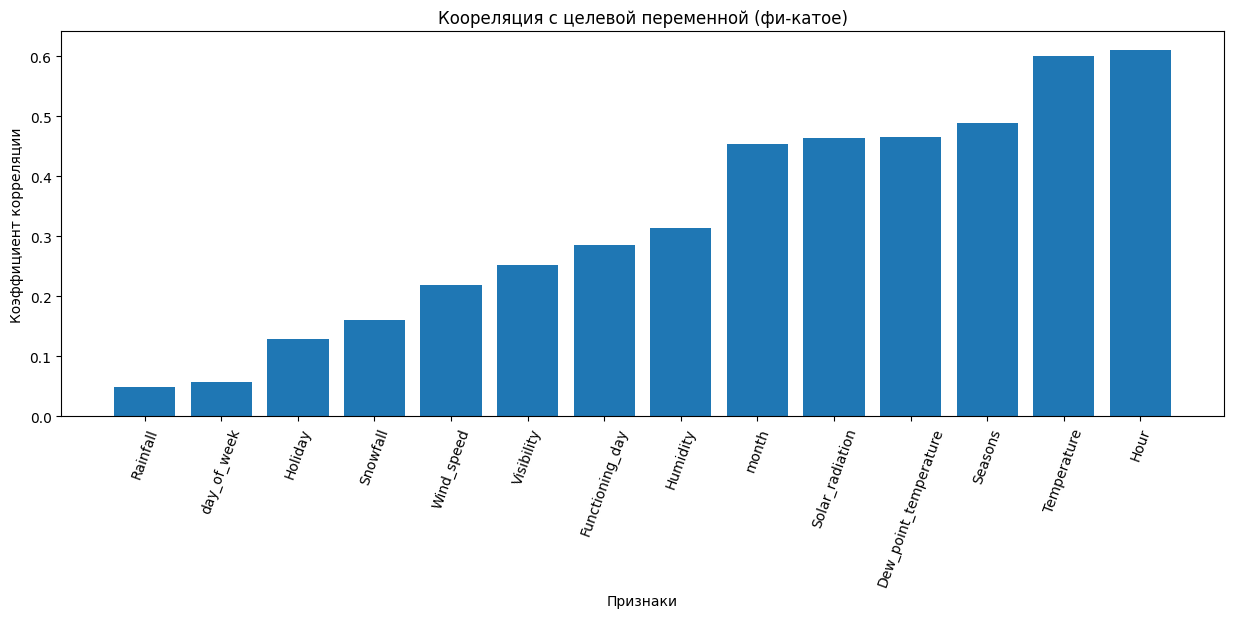

In [11]:
corr_with_target = data.phik_matrix()['Rented_bike_count'].abs().sort_values()
corr_with_target = corr_with_target.drop("Rented_bike_count")
plt.figure(figsize=(15,5))
plt.bar(corr_with_target.index, corr_with_target.values)
plt.title("Коореляция с целевой переменной (фи-катое)")
plt.xlabel("Признаки")
plt.ylabel('Коэффициент корреляции')
plt.xticks(rotation=70)
plt.show()

interval columns not set, guessing: ['Rented_bike_count', 'Hour', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Solar_radiation', 'Rainfall', 'Snowfall']


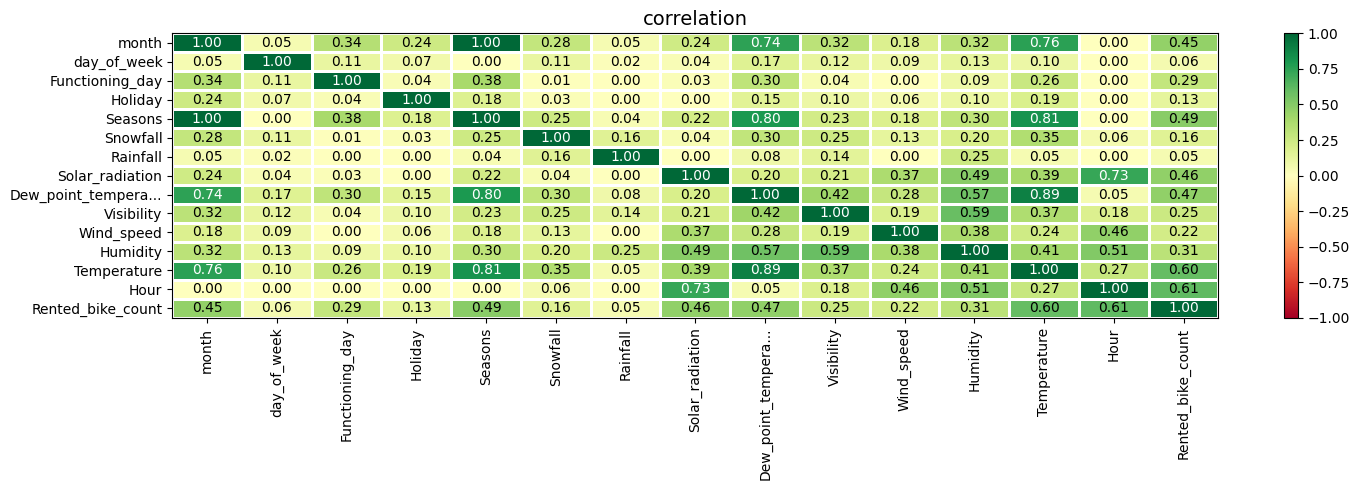

In [12]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, figsize=(15, 5))

In [13]:
# делаем кодирование категориальных данных
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Rented_bike_count'], axis=1), data['Rented_bike_count'],  random_state=42)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop = 'first'), make_column_selector(dtype_include=[object, 'category']))) #заменить на все столбцы с делением на тип данных
lr_pipeline = make_pipeline(preprocessor, StandardScaler(with_mean=False), PolynomialFeatures(degree=3, include_bias=False), ElasticNet(random_state=42))
lr_pipeline.fit(X_train, y_train)
# Извлечение предварительного процессора из пайплайна
preprocessor_step = lr_pipeline.named_steps['columntransformer']
# Преобразование данных с помощью предварительного процессора
transformed_data = pd.DataFrame(preprocessor_step.transform(X_train))
# Преобразование результата в DataFrame для удобства просмотра
transformed_df = pd.DataFrame(transformed_data, columns=preprocessor_step.get_feature_names_out())
# Вывод преобразованных данных
transformed_df
# # объединяем датафреймы (исходный и с закодированными данными)
X_train_encoded = pd.concat([X_train.reset_index(drop=True), transformed_df.reset_index(drop=True)], axis=1)

In [14]:
# строим простую модель
kf = KFold(n_splits=5)
cv_metrics = cross_validate(
    estimator=lr_pipeline,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring='r2',
    return_train_score=True
)
n = X_train.shape[0]
k = X_train.shape[1]
adjusted_r2 = 1 - (1 - cv_metrics['train_score'].mean()) * (n - 1) / (n - k - 1)
print(f"Adj R^2: {adjusted_r2:.4f}")
print(f"Среднее качество на тренировочной выборке: {cv_metrics['train_score'].mean():.4f}")
print(f"Среднее качество на валидационной выборке: {cv_metrics['test_score'].mean():.4f}")

Adj R^2: 0.3465
Среднее качество на тренировочной выборке: 0.3479
Среднее качество на валидационной выборке: 0.3180


In [15]:
kf = KFold(n_splits=5)
param_grid = {
    'elasticnet__alpha': np.linspace(0, 2000, 10),
    'elasticnet__l1_ratio': np.linspace(0, 1, 10)
}
halving_search = HalvingGridSearchCV(lr_pipeline,
                                     param_grid=param_grid,
                                     scoring='r2',
                                     n_jobs=-1,
                                     cv=KFold(3, shuffle=True, random_state=42),
                                     random_state=42)
halving_search.fit(X_train, y_train)
n = X_train.shape[0]
k = X_train.shape[1]
adjusted_r2 = 1 - (1 - halving_search.best_score_) * (n - 1) / (n - k - 1)
print(f"Adj R^2: {adjusted_r2:.4f}")
print(f"Наилучшее значение R2 при кросс-валидации: {halving_search.best_score_}")
print(f"Наилучшие значения параметров: {halving_search.best_params_}")

Adj R^2: 0.3128
Наилучшее значение R2 при кросс-валидации: 0.3142699985025718
Наилучшие значения параметров: {'elasticnet__alpha': 444.44444444444446, 'elasticnet__l1_ratio': 1.0}


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Rented_bike_count', 'Rainfall'], axis=1), data['Rented_bike_count'],  random_state=42)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop = 'first'), ['Seasons', 'Holiday', 'Functioning_day', 'day_of_week', 'month']))
lr_pipeline = make_pipeline(preprocessor, StandardScaler(with_mean=False), PolynomialFeatures(degree=3, include_bias=False), ElasticNet(random_state=42))
lr_pipeline.fit(X_train, y_train)
kf = KFold(n_splits=5)
param_grid = {
    'elasticnet__alpha': np.linspace(0, 2000, 10),
    'elasticnet__l1_ratio': np.linspace(0, 1, 10)
}
halving_search = HalvingGridSearchCV(lr_pipeline,
                                     param_grid=param_grid,
                                     scoring='r2',
                                     n_jobs=-1,
                                     cv=KFold(3, shuffle=True, random_state=42),
                                     random_state=42)
halving_search.fit(X_train, y_train)
n = X_train.shape[0]
k = X_train.shape[1]
adjusted_r2 = 1 - (1 - halving_search.best_score_) * (n - 1) / (n - k - 1)
print(f"Adj R^2: {adjusted_r2:.4f}")
print(f"Наилучшее значение R2 при кросс-валидации: {halving_search.best_score_}")
print(f"Наилучшие значения параметров: {halving_search.best_params_}")

Adj R^2: 0.3129
Наилучшее значение R2 при кросс-валидации: 0.3142699985025718
Наилучшие значения параметров: {'elasticnet__alpha': 444.44444444444446, 'elasticnet__l1_ratio': 1.0}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Rented_bike_count', 'Rainfall', 'day_of_week', 'Holiday', "Snowfall", 'Wind_speed', "Visibility" ], axis=1), data['Rented_bike_count'],  random_state=42)
preprocessor = make_column_transformer(
    (OneHotEncoder(drop = 'first'), ['Seasons', 'Functioning_day', 'month']))
lr_pipeline = make_pipeline(preprocessor, StandardScaler(with_mean=False), PolynomialFeatures(degree=3, include_bias=False), ElasticNet(random_state=42))
lr_pipeline.fit(X_train, y_train)
kf = KFold(n_splits=5)
param_grid = {
    'elasticnet__alpha': np.linspace(0, 2000, 10),
    'elasticnet__l1_ratio': np.linspace(0, 1, 10)
}
halving_search = HalvingGridSearchCV(lr_pipeline,
                                     param_grid=param_grid,
                                     scoring='r2',
                                     n_jobs=-1,
                                     cv=KFold(3, shuffle=True, random_state=42),
                                     random_state=42)
halving_search.fit(X_train, y_train)
n = X_train.shape[0]
k = X_train.shape[1]
adjusted_r2 = 1 - (1 - halving_search.best_score_) * (n - 1) / (n - k - 1)
print(f"Adj R^2: {adjusted_r2:.4f}")
print(f"Наилучшее значение R2 при кросс-валидации: {halving_search.best_score_}")
print(f"Наилучшие значения параметров: {halving_search.best_params_}")


Adj R^2: 0.3142
Наилучшее значение R2 при кросс-валидации: 0.31505442979015325
Наилучшие значения параметров: {'elasticnet__alpha': 0.0, 'elasticnet__l1_ratio': 0.4444444444444444}


In [18]:
cat_features = ['Seasons',   'Functioning_day', 'month', 'Holiday', 'day_of_week']
numeric_features = ['Hour', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Snowfall', 'Rainfall', 'Dew_point_temperature', 'Solar_radiation']

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Rented_bike_count'], axis=1), data['Rented_bike_count'],  random_state=42)

In [19]:
# Создаем объект Pool для CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# Создаем и устанавливаем параметры CatBoost с указанием функции потерь и метрик
params = {
    'random_seed': 42,
    'cat_features': cat_features,
    'custom_metric': 'R2',  
    'loss_function': 'RMSE'  
}

In [20]:
# Обучение модели с использованием кросс-валидации
cv_results = cv(
    train_pool,
    params,
    nfold=5,
    shuffle=True,
    as_pandas=True,  
    early_stopping_rounds=100  
)

Training on fold [0/5]
0:	learn: 931.6899163	test: 942.5103150	best: 942.5103150 (0)	total: 162ms	remaining: 2m 41s
1:	learn: 908.6901084	test: 919.7414572	best: 919.7414572 (1)	total: 190ms	remaining: 1m 34s
2:	learn: 887.1193618	test: 898.3433907	best: 898.3433907 (2)	total: 215ms	remaining: 1m 11s
3:	learn: 866.7886942	test: 877.9187836	best: 877.9187836 (3)	total: 240ms	remaining: 59.8s
4:	learn: 846.4231940	test: 857.7830323	best: 857.7830323 (4)	total: 266ms	remaining: 52.9s
5:	learn: 828.2761919	test: 839.7825412	best: 839.7825412 (5)	total: 290ms	remaining: 48s
6:	learn: 809.4654378	test: 821.0317985	best: 821.0317985 (6)	total: 343ms	remaining: 48.7s
7:	learn: 791.1841131	test: 802.3541191	best: 802.3541191 (7)	total: 391ms	remaining: 48.5s
8:	learn: 772.6937723	test: 783.8705199	best: 783.8705199 (8)	total: 422ms	remaining: 46.5s
9:	learn: 755.6711509	test: 766.7828933	best: 766.7828933 (9)	total: 448ms	remaining: 44.3s
10:	learn: 738.9797308	test: 749.9054593	best: 749.90545

In [21]:
# Получение и вывод лучших результатов
best_result = cv_results['test-R2-mean'].max()
print(f"Лучшее значение точности на кросс-валидации: {best_result:.4f}")

Лучшее значение точности на кросс-валидации: 0.9214


In [22]:
# Обучаем модель
cbr = CatBoostRegressor(**params)
cbr.fit(train_pool)

Learning rate set to 0.055126
0:	learn: 625.1057734	total: 37ms	remaining: 36.9s
1:	learn: 603.6040469	total: 62.1ms	remaining: 31s
2:	learn: 583.9189557	total: 87.3ms	remaining: 29s
3:	learn: 563.6413907	total: 113ms	remaining: 28.1s
4:	learn: 544.5775089	total: 194ms	remaining: 38.6s
5:	learn: 527.7632594	total: 292ms	remaining: 48.3s
6:	learn: 512.1620034	total: 343ms	remaining: 48.7s
7:	learn: 497.1542342	total: 378ms	remaining: 46.8s
8:	learn: 482.2104252	total: 476ms	remaining: 52.4s
9:	learn: 469.5073794	total: 520ms	remaining: 51.5s
10:	learn: 458.4918743	total: 553ms	remaining: 49.7s
11:	learn: 446.5576265	total: 578ms	remaining: 47.5s
12:	learn: 435.8988329	total: 600ms	remaining: 45.6s
13:	learn: 426.5112457	total: 638ms	remaining: 44.9s
14:	learn: 417.0199714	total: 735ms	remaining: 48.3s
15:	learn: 407.8511601	total: 796ms	remaining: 49s
16:	learn: 399.2296062	total: 825ms	remaining: 47.7s
17:	learn: 391.8332608	total: 849ms	remaining: 46.3s
18:	learn: 384.6828715	total: 8

In [23]:
# Получаем важность признаков
feature_importances = cbr.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))

In [24]:
# Создаем DataFrame для удобства отображения
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

In [25]:
# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

Feature  Importance
0                    Hour   35.368827
1             Temperature   19.175362
11        Functioning_day    9.609803
6         Solar_radiation    8.217894
2                Humidity    6.542427
9                 Seasons    5.017048
7                Rainfall    4.639749
5   Dew_point_temperature    3.571910
13                  month    3.445550
12            day_of_week    1.964929
4              Visibility    0.914919
3              Wind_speed    0.804731
10                Holiday    0.636067
8                Snowfall    0.090782

In [26]:
cbr_pred = cbr.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
r2 = r2_score(y_test,cbr_pred)
print(r2)

0.9305111878660353


In [28]:
n = X_test.shape[0]
k = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(adjusted_r2)

0.9300639035580465


In [29]:
# Создаем объект Pool для CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
# Создаем объект CatBoostClassifier
cbr_1 = CatBoostRegressor(
    random_seed=42,
    loss_function='RMSE',
    custom_metric="R2",
)

In [30]:
# Определяем параметры для GridSearch
grid = {
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 1000]
}

In [31]:
# Выполнение Grid Search
grid_search_result = cbr_1.grid_search(
    grid,
    train_pool,
    cv=5,  
    stratified=True,
    shuffle=True,
    verbose=1  
)

0:	learn: 952.4931468	test: 939.6933399	best: 939.6933399 (0)	total: 17.6ms	remaining: 1.74s
1:	learn: 945.4850081	test: 932.6601800	best: 932.6601800 (1)	total: 36ms	remaining: 1.76s
2:	learn: 938.5382249	test: 925.6877174	best: 925.6877174 (2)	total: 56.3ms	remaining: 1.82s
3:	learn: 931.6812674	test: 918.7955232	best: 918.7955232 (3)	total: 77.7ms	remaining: 1.86s
4:	learn: 924.9744865	test: 912.2009628	best: 912.2009628 (4)	total: 92.8ms	remaining: 1.76s
5:	learn: 918.1522475	test: 905.2901328	best: 905.2901328 (5)	total: 105ms	remaining: 1.64s
6:	learn: 911.6223463	test: 898.7737851	best: 898.7737851 (6)	total: 119ms	remaining: 1.57s
7:	learn: 904.9318807	test: 892.0721311	best: 892.0721311 (7)	total: 130ms	remaining: 1.49s
8:	learn: 898.2764156	test: 885.3477783	best: 885.3477783 (8)	total: 140ms	remaining: 1.42s
9:	learn: 891.8979024	test: 878.9339494	best: 878.9339494 (9)	total: 151ms	remaining: 1.36s
10:	learn: 885.5493005	test: 872.5625742	best: 872.5625742 (10)	total: 163ms	

0:	learn: 700.7869168	test: 1164.7034500	best: 1164.7034500 (0)	total: 99.9ms	remaining: 1m 39s
1:	learn: 647.5007369	test: 1097.3076524	best: 1097.3076524 (1)	total: 148ms	remaining: 1m 13s
2:	learn: 600.4995037	test: 1036.5889918	best: 1036.5889918 (2)	total: 171ms	remaining: 56.8s
3:	learn: 556.9028968	test: 974.3238503	best: 974.3238503 (3)	total: 191ms	remaining: 47.5s
4:	learn: 520.9596761	test: 925.1564014	best: 925.1564014 (4)	total: 214ms	remaining: 42.6s
5:	learn: 487.4937886	test: 879.2696359	best: 879.2696359 (5)	total: 238ms	remaining: 39.5s
6:	learn: 459.0053981	test: 834.9565891	best: 834.9565891 (6)	total: 262ms	remaining: 37.1s
7:	learn: 433.3322378	test: 793.9584353	best: 793.9584353 (7)	total: 286ms	remaining: 35.5s
8:	learn: 411.2098736	test: 762.6754516	best: 762.6754516 (8)	total: 308ms	remaining: 33.9s
9:	learn: 391.3384946	test: 733.4884696	best: 733.4884696 (9)	total: 335ms	remaining: 33.2s
10:	learn: 371.5962539	test: 698.5368083	best: 698.5368083 (10)	total: 

5:	learn: 611.6016371	test: 579.8526678	best: 579.8526678 (5)	total: 189ms	remaining: 31.2s
6:	learn: 572.1305199	test: 541.5884455	best: 541.5884455 (6)	total: 252ms	remaining: 35.8s
7:	learn: 539.2175341	test: 508.1265752	best: 508.1265752 (7)	total: 295ms	remaining: 36.6s
8:	learn: 508.1516260	test: 476.1400316	best: 476.1400316 (8)	total: 318ms	remaining: 35s
9:	learn: 480.4496408	test: 449.1229530	best: 449.1229530 (9)	total: 341ms	remaining: 33.7s
10:	learn: 455.1857382	test: 426.1537077	best: 426.1537077 (10)	total: 369ms	remaining: 33.2s
11:	learn: 433.0205614	test: 405.3233289	best: 405.3233289 (11)	total: 394ms	remaining: 32.4s
12:	learn: 415.5933882	test: 387.3629357	best: 387.3629357 (12)	total: 423ms	remaining: 32.1s
13:	learn: 398.4439639	test: 371.7774144	best: 371.7774144 (13)	total: 477ms	remaining: 33.6s
14:	learn: 384.1721472	test: 359.4758177	best: 359.4758177 (14)	total: 568ms	remaining: 37.3s
15:	learn: 371.4698337	test: 347.8582628	best: 347.8582628 (15)	total: 6

2:	learn: 788.4954217	test: 533.4169996	best: 533.4169996 (2)	total: 90.8ms	remaining: 30.2s
3:	learn: 729.7340579	test: 485.4954087	best: 485.4954087 (3)	total: 119ms	remaining: 29.6s
4:	learn: 681.6465295	test: 447.0543523	best: 447.0543523 (4)	total: 150ms	remaining: 29.8s
5:	learn: 637.2006960	test: 413.6211433	best: 413.6211433 (5)	total: 189ms	remaining: 31.3s
6:	learn: 598.2271583	test: 385.9198277	best: 385.9198277 (6)	total: 271ms	remaining: 38.5s
7:	learn: 558.8868425	test: 358.2678810	best: 358.2678810 (7)	total: 339ms	remaining: 42s
8:	learn: 527.1337599	test: 336.0889365	best: 336.0889365 (8)	total: 368ms	remaining: 40.5s
9:	learn: 496.2997927	test: 317.0343230	best: 317.0343230 (9)	total: 393ms	remaining: 38.9s
10:	learn: 471.5491024	test: 303.2397014	best: 303.2397014 (10)	total: 418ms	remaining: 37.6s
11:	learn: 450.9363324	test: 287.3564007	best: 287.3564007 (11)	total: 446ms	remaining: 36.7s
12:	learn: 430.9091842	test: 276.5247082	best: 276.5247082 (12)	total: 472ms	

0:	learn: 917.7658143	test: 516.3328564	best: 516.3328564 (0)	total: 45.8ms	remaining: 45.8s
1:	learn: 850.3071174	test: 470.1655582	best: 470.1655582 (1)	total: 68.3ms	remaining: 34.1s
2:	learn: 783.9363569	test: 426.6385548	best: 426.6385548 (2)	total: 91.2ms	remaining: 30.3s
3:	learn: 730.2048259	test: 387.3601402	best: 387.3601402 (3)	total: 120ms	remaining: 30s
4:	learn: 679.9987208	test: 358.4174610	best: 358.4174610 (4)	total: 144ms	remaining: 28.7s
5:	learn: 634.3064389	test: 327.1532771	best: 327.1532771 (5)	total: 169ms	remaining: 28s
6:	learn: 593.5294464	test: 301.3977504	best: 301.3977504 (6)	total: 248ms	remaining: 35.2s
7:	learn: 556.2739804	test: 281.7840291	best: 281.7840291 (7)	total: 322ms	remaining: 40s
8:	learn: 525.9405293	test: 262.3130803	best: 262.3130803 (8)	total: 345ms	remaining: 38s
9:	learn: 498.4401276	test: 252.5408746	best: 252.5408746 (9)	total: 368ms	remaining: 36.4s
10:	learn: 476.5924869	test: 246.2364012	best: 246.2364012 (10)	total: 391ms	remainin

0:	learn: 916.2489900	test: 401.3698987	best: 401.3698987 (0)	total: 23.7ms	remaining: 23.6s
1:	learn: 841.1737396	test: 358.2562086	best: 358.2562086 (1)	total: 50ms	remaining: 24.9s
2:	learn: 781.1211800	test: 324.8535484	best: 324.8535484 (2)	total: 73.9ms	remaining: 24.5s
3:	learn: 725.8562052	test: 293.3691924	best: 293.3691924 (3)	total: 99.8ms	remaining: 24.9s
4:	learn: 672.7372378	test: 266.4660261	best: 266.4660261 (4)	total: 132ms	remaining: 26.2s
5:	learn: 626.7656947	test: 244.9627903	best: 244.9627903 (5)	total: 158ms	remaining: 26.2s
6:	learn: 587.3742540	test: 230.2126037	best: 230.2126037 (6)	total: 185ms	remaining: 26.2s
7:	learn: 551.6077775	test: 221.4518996	best: 221.4518996 (7)	total: 213ms	remaining: 26.5s
8:	learn: 518.6101045	test: 211.4437326	best: 211.4437326 (8)	total: 244ms	remaining: 26.8s
9:	learn: 490.5240904	test: 206.5923804	best: 206.5923804 (9)	total: 269ms	remaining: 26.6s
10:	learn: 465.7874459	test: 198.9094475	best: 198.9094475 (10)	total: 298ms	r

In [32]:
# Выводим результаты лучшей модели
print(f"Лучшие параметры: {grid_search_result['params']}")
best_result = cv_results['test-RMSE-mean'].max()
print(f"Лучшее значение точности на кросс-валидации: {best_result:.4f}")

Лучшие параметры: {'depth': 6, 'learning_rate': 0.1, 'iterations': 1000}
Лучшее значение точности на кросс-валидации: 934.4581


In [33]:
cbr_1.fit(train_pool)
cbr_1_pred = cbr_1.predict(X_test)
r2 = r2_score(y_test,cbr_1_pred)
print(r2)

0:	learn: 607.8895976	total: 72ms	remaining: 1m 11s
1:	learn: 571.7683069	total: 152ms	remaining: 1m 15s
2:	learn: 538.3333205	total: 213ms	remaining: 1m 10s
3:	learn: 507.5591996	total: 282ms	remaining: 1m 10s
4:	learn: 480.0346805	total: 312ms	remaining: 1m 2s
5:	learn: 456.4673399	total: 337ms	remaining: 55.7s
6:	learn: 437.6108708	total: 411ms	remaining: 58.2s
7:	learn: 420.7215467	total: 479ms	remaining: 59.4s
8:	learn: 403.7052678	total: 510ms	remaining: 56.1s
9:	learn: 390.2417592	total: 539ms	remaining: 53.3s
10:	learn: 377.6613883	total: 574ms	remaining: 51.6s
11:	learn: 366.8946344	total: 641ms	remaining: 52.8s
12:	learn: 357.0713058	total: 679ms	remaining: 51.6s
13:	learn: 348.0777059	total: 768ms	remaining: 54.1s
14:	learn: 340.7112740	total: 878ms	remaining: 57.7s
15:	learn: 333.4175074	total: 942ms	remaining: 57.9s
16:	learn: 326.8722842	total: 977ms	remaining: 56.5s
17:	learn: 321.4785034	total: 1.01s	remaining: 54.9s
18:	learn: 317.0626260	total: 1.05s	remaining: 54.3s


In [34]:
n = X_test.shape[0]
k = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(adjusted_r2)

0.9351990703113243
